In [1]:
import numpy as np
import soundfile as sf
import os
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import find_peaks
import librosa
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
FRAME_TIME = 30e-3
FRAME_SHIFT_TIME = 10e-3
THRESHOLD_VOWEL_SILENCE_BY_ENERGY = 8.5e-3

def get_frames(signal, fs):
    signal_sample = len(signal)
    frame_sample = int(FRAME_TIME * fs)
    frame_shift_sample = int(FRAME_SHIFT_TIME * fs)
    left, right = 0, frame_sample
    frames = []
    while right < signal_sample:
        frames.append(signal[left:right])
        left += frame_shift_sample
        right += frame_shift_sample
    return np.array(frames)

def energy(x):
    return np.sum(x * x)

def get_frame_vowel(signal, fs):
    frames = get_frames(signal, fs)
    max_energy = 0
    for frame in frames:
        max_energy = max(max_energy, energy(frame))
    frame_vowel = []
    for frame in frames:
        if energy(frame) >= max_energy * THRESHOLD_VOWEL_SILENCE_BY_ENERGY:
            frame_vowel.append(frame)
    n = len(frame_vowel)
    return frame_vowel[n // 3 : n // 3 * 2]

def plot_confusion_matrix(y_true, y_pred, labels):
    matrix = confusion_matrix(y_true, y_pred)    
    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(matrix, cmap=plt.cm.Blues)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    for i, true_label in enumerate(matrix):
        for j, predicted_label in enumerate(true_label):
            text = ax.text(j, i, matrix[i, j], ha="center", va="center", fontweight='bold');
    plt.title("Confusion Matrix")

In [55]:
N_MFCC = 26

rate_26 = []

for t in range(5):
    rate = []
    for N_CLUSTERS in range(1, 7):
        # TRAIN
        vowels = ['a', 'e', 'i', 'o', 'u']
        training_folder = './NguyenAmHuanLuyen-16k' 
        training_folders = []
        for folder in os.listdir(training_folder):
            training_folders.append(folder)

        vowels_feature = {}

        for vowel in vowels:
            features = []

            for folder in training_folders:
                signal, fs = sf.read(training_folder + '/' + folder + '/' + vowel + '.wav')
                signal = signal / np.max(signal)
                frames = get_frame_vowel(signal, fs)
                mfccs = []
                for frame in frames:
                    S = librosa.feature.melspectrogram(y=frame, sr=fs)
                    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=N_MFCC)
                    mfcc = mfcc.T[0]
                    mfccs.append(mfcc)

                feature = np.mean(mfccs, axis=0) 
                features.append(feature)

            kmeans = KMeans(n_clusters=N_CLUSTERS).fit(features)
            clusters = kmeans.cluster_centers_
            vowels_feature[vowel] = clusters


        # TEST

        vowels = ['a', 'e', 'i', 'o', 'u']
        testing_folder = './NguyenAmKiemThu-16k' 
        testing_folders = []
        for folder in os.listdir(testing_folder):
            testing_folders.append(folder)

        y_true = []
        y_pred = []
        ok = 0

        for vowel in vowels:

            for folder in testing_folders:
                signal, fs = sf.read(testing_folder + '/' + folder + '/' + vowel + '.wav')
                signal = signal / np.max(signal)
                frames = get_frame_vowel(signal, fs)
                mfccs = []
                for frame in frames:
                    S = librosa.feature.melspectrogram(y=frame, sr=fs)
                    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=N_MFCC)
                    mfcc = mfcc.T[0]
                    mfccs.append(mfcc)

                feature = np.mean(mfccs, axis=0) 

                y_true.append(vowel)

                predict_vowel = '#'
                min_dist = 1e20
                for v in vowels:
                    for i in vowels_feature[v]:
                        dist = np.linalg.norm(feature - i)
                        if dist < min_dist:
                            min_dist = dist
                            predict_vowel = v

                y_pred.append(predict_vowel)

                if vowel == predict_vowel:
                    ok += 1
        rate.append(ok / len(y_pred) * 100)
    rate_26.append(rate)
print(rate_26)

[[87.61904761904762, 88.57142857142857, 88.57142857142857, 87.61904761904762, 87.61904761904762, 90.47619047619048], [87.61904761904762, 88.57142857142857, 89.52380952380953, 85.71428571428571, 90.47619047619048, 89.52380952380953], [87.61904761904762, 88.57142857142857, 87.61904761904762, 87.61904761904762, 88.57142857142857, 89.52380952380953], [87.61904761904762, 88.57142857142857, 88.57142857142857, 89.52380952380953, 87.61904761904762, 90.47619047619048], [87.61904761904762, 88.57142857142857, 91.42857142857143, 88.57142857142857, 91.42857142857143, 89.52380952380953]]


In [60]:
rate_26

[[87.61904761904762,
  88.57142857142857,
  88.57142857142857,
  87.61904761904762,
  87.61904761904762,
  90.47619047619048],
 [87.61904761904762,
  88.57142857142857,
  89.52380952380953,
  85.71428571428571,
  90.47619047619048,
  89.52380952380953],
 [87.61904761904762,
  88.57142857142857,
  87.61904761904762,
  87.61904761904762,
  88.57142857142857,
  89.52380952380953],
 [87.61904761904762,
  88.57142857142857,
  88.57142857142857,
  89.52380952380953,
  87.61904761904762,
  90.47619047619048],
 [87.61904761904762,
  88.57142857142857,
  91.42857142857143,
  88.57142857142857,
  91.42857142857143,
  89.52380952380953]]

In [57]:
N_MFCC = 13

rate_13 = []

for t in range(5):
    rate = []
    for N_CLUSTERS in range(1, 7):
        # TRAIN
        vowels = ['a', 'e', 'i', 'o', 'u']
        training_folder = './NguyenAmHuanLuyen-16k' 
        training_folders = []
        for folder in os.listdir(training_folder):
            training_folders.append(folder)

        vowels_feature = {}

        for vowel in vowels:
            features = []

            for folder in training_folders:
                signal, fs = sf.read(training_folder + '/' + folder + '/' + vowel + '.wav')
                signal = signal / np.max(signal)
                frames = get_frame_vowel(signal, fs)
                mfccs = []
                for frame in frames:
                    S = librosa.feature.melspectrogram(y=frame, sr=fs)
                    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=N_MFCC)
                    mfcc = mfcc.T[0]
                    mfccs.append(mfcc)

                feature = np.mean(mfccs, axis=0) 
                features.append(feature)

            kmeans = KMeans(n_clusters=N_CLUSTERS).fit(features)
            clusters = kmeans.cluster_centers_
            vowels_feature[vowel] = clusters


        # TEST

        vowels = ['a', 'e', 'i', 'o', 'u']
        testing_folder = './NguyenAmKiemThu-16k' 
        testing_folders = []
        for folder in os.listdir(testing_folder):
            testing_folders.append(folder)

        y_true = []
        y_pred = []
        ok = 0

        for vowel in vowels:

            for folder in testing_folders:
                signal, fs = sf.read(testing_folder + '/' + folder + '/' + vowel + '.wav')
                signal = signal / np.max(signal)
                frames = get_frame_vowel(signal, fs)
                mfccs = []
                for frame in frames:
                    S = librosa.feature.melspectrogram(y=frame, sr=fs)
                    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=N_MFCC)
                    mfcc = mfcc.T[0]
                    mfccs.append(mfcc)

                feature = np.mean(mfccs, axis=0) 

                y_true.append(vowel)

                predict_vowel = '#'
                min_dist = 1e20
                for v in vowels:
                    for i in vowels_feature[v]:
                        dist = np.linalg.norm(feature - i)
                        if dist < min_dist:
                            min_dist = dist
                            predict_vowel = v

                y_pred.append(predict_vowel)

                if vowel == predict_vowel:
                    ok += 1
        rate.append(ok / len(y_pred) * 100)
    rate_13.append(rate)
print(rate_13)

[[87.61904761904762, 89.52380952380953, 87.61904761904762, 88.57142857142857, 86.66666666666667, 91.42857142857143], [87.61904761904762, 88.57142857142857, 88.57142857142857, 89.52380952380953, 91.42857142857143, 89.52380952380953], [87.61904761904762, 88.57142857142857, 88.57142857142857, 88.57142857142857, 89.52380952380953, 88.57142857142857], [87.61904761904762, 88.57142857142857, 88.57142857142857, 88.57142857142857, 90.47619047619048, 85.71428571428571], [87.61904761904762, 88.57142857142857, 87.61904761904762, 88.57142857142857, 87.61904761904762, 87.61904761904762]]


In [67]:
df = pd.DataFrame(rate_13, columns =['K = 1', 'K = 2', 'K = 3', 'K = 4', 'K = 5', 'K = 6']) 
df.round(2)

,K = 1,K = 2,K = 3,K = 4,K = 5,K = 6
0,87.62,89.52,87.62,88.57,86.67,91.43
1,87.62,88.57,88.57,89.52,91.43,89.52
2,87.62,88.57,88.57,88.57,89.52,88.57
3,87.62,88.57,88.57,88.57,90.48,85.71
4,87.62,88.57,87.62,88.57,87.62,87.62


In [66]:
N_MFCC = 39

rate_39 = []

for t in range(5):
    rate = []
    for N_CLUSTERS in range(1, 7):
        # TRAIN
        vowels = ['a', 'e', 'i', 'o', 'u']
        training_folder = './NguyenAmHuanLuyen-16k' 
        training_folders = []
        for folder in os.listdir(training_folder):
            training_folders.append(folder)

        vowels_feature = {}

        for vowel in vowels:
            features = []

            for folder in training_folders:
                signal, fs = sf.read(training_folder + '/' + folder + '/' + vowel + '.wav')
                signal = signal / np.max(signal)
                frames = get_frame_vowel(signal, fs)
                mfccs = []
                for frame in frames:
                    S = librosa.feature.melspectrogram(y=frame, sr=fs)
                    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=N_MFCC)
                    mfcc = mfcc.T[0]
                    mfccs.append(mfcc)

                feature = np.mean(mfccs, axis=0) 
                features.append(feature)

            kmeans = KMeans(n_clusters=N_CLUSTERS).fit(features)
            clusters = kmeans.cluster_centers_
            vowels_feature[vowel] = clusters


        # TEST

        vowels = ['a', 'e', 'i', 'o', 'u']
        testing_folder = './NguyenAmKiemThu-16k' 
        testing_folders = []
        for folder in os.listdir(testing_folder):
            testing_folders.append(folder)

        y_true = []
        y_pred = []
        ok = 0

        for vowel in vowels:

            for folder in testing_folders:
                signal, fs = sf.read(testing_folder + '/' + folder + '/' + vowel + '.wav')
                signal = signal / np.max(signal)
                frames = get_frame_vowel(signal, fs)
                mfccs = []
                for frame in frames:
                    S = librosa.feature.melspectrogram(y=frame, sr=fs)
                    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=N_MFCC)
                    mfcc = mfcc.T[0]
                    mfccs.append(mfcc)

                feature = np.mean(mfccs, axis=0) 

                y_true.append(vowel)

                predict_vowel = '#'
                min_dist = 1e20
                for v in vowels:
                    for i in vowels_feature[v]:
                        dist = np.linalg.norm(feature - i)
                        if dist < min_dist:
                            min_dist = dist
                            predict_vowel = v

                y_pred.append(predict_vowel)

                if vowel == predict_vowel:
                    ok += 1
        rate.append(ok / len(y_pred) * 100)
    rate_39.append(rate)
print(rate_39)

[[87.61904761904762, 88.57142857142857, 90.47619047619048, 89.52380952380953, 90.47619047619048, 89.52380952380953], [87.61904761904762, 89.52380952380953, 88.57142857142857, 87.61904761904762, 90.47619047619048, 88.57142857142857], [87.61904761904762, 88.57142857142857, 88.57142857142857, 86.66666666666667, 87.61904761904762, 91.42857142857143], [87.61904761904762, 90.47619047619048, 89.52380952380953, 86.66666666666667, 88.57142857142857, 90.47619047619048], [87.61904761904762, 88.57142857142857, 91.42857142857143, 89.52380952380953, 89.52380952380953, 87.61904761904762]]


In [82]:
df = pd.DataFrame(rate_13, columns =['K = 1', 'K = 2', 'K = 3', 'K = 4', 'K = 5', 'K = 6']) 
print(df.round(2))
print(df.mean().round(2))

   K = 1  K = 2  K = 3  K = 4  K = 5  K = 6
0  87.62  89.52  87.62  88.57  86.67  91.43
1  87.62  88.57  88.57  89.52  91.43  89.52
2  87.62  88.57  88.57  88.57  89.52  88.57
3  87.62  88.57  88.57  88.57  90.48  85.71
4  87.62  88.57  87.62  88.57  87.62  87.62
K = 1    87.62
K = 2    88.76
K = 3    88.19
K = 4    88.76
K = 5    89.14
K = 6    88.57
dtype: float64


In [83]:
df = pd.DataFrame(rate_26, columns =['K = 1', 'K = 2', 'K = 3', 'K = 4', 'K = 5', 'K = 6']) 
print(df.round(2))
print(df.mean().round(2))

   K = 1  K = 2  K = 3  K = 4  K = 5  K = 6
0  87.62  88.57  88.57  87.62  87.62  90.48
1  87.62  88.57  89.52  85.71  90.48  89.52
2  87.62  88.57  87.62  87.62  88.57  89.52
3  87.62  88.57  88.57  89.52  87.62  90.48
4  87.62  88.57  91.43  88.57  91.43  89.52
K = 1    87.62
K = 2    88.57
K = 3    89.14
K = 4    87.81
K = 5    89.14
K = 6    89.90
dtype: float64


In [84]:
df = pd.DataFrame(rate_39, columns =['K = 1', 'K = 2', 'K = 3', 'K = 4', 'K = 5', 'K = 6']) 
print(df.round(2))
print(df.mean().round(2))

   K = 1  K = 2  K = 3  K = 4  K = 5  K = 6
0  87.62  88.57  90.48  89.52  90.48  89.52
1  87.62  89.52  88.57  87.62  90.48  88.57
2  87.62  88.57  88.57  86.67  87.62  91.43
3  87.62  90.48  89.52  86.67  88.57  90.48
4  87.62  88.57  91.43  89.52  89.52  87.62
K = 1    87.62
K = 2    89.14
K = 3    89.71
K = 4    88.00
K = 5    89.33
K = 6    89.52
dtype: float64


In [85]:
df.round(2)

,K = 1,K = 2,K = 3,K = 4,K = 5,K = 6
0,87.62,88.57,90.48,89.52,90.48,89.52
1,87.62,89.52,88.57,87.62,90.48,88.57
2,87.62,88.57,88.57,86.67,87.62,91.43
3,87.62,90.48,89.52,86.67,88.57,90.48
4,87.62,88.57,91.43,89.52,89.52,87.62


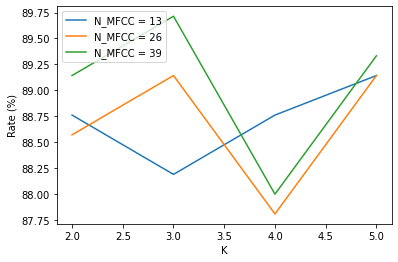

In [98]:
plt.plot(np.arange(2, 6), np.mean(rate_13, axis=0) [1:5], label='N_MFCC = 13')
plt.plot(np.arange(2, 6), np.mean(rate_26, axis=0) [1:5], label='N_MFCC = 26')
plt.plot(np.arange(2, 6), np.mean(rate_39, axis=0) [1:5], label='N_MFCC = 39')
plt.legend()
plt.xlabel('K')
plt.ylabel('Rate (%)')
plt.savefig('DIFF_K.png')